In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all words
words = open("names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# mapping from each letter to integer and vice versa
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context_length; how many characters do we use to support our prediction of the next character?
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size # padded context of 0-tokens (i.e. ".")
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix] # shift/move the context window one character to the right --> rolling window of context

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
# We have 32 Input character sequences of block size 3 for these 5 Words
# Each of these 32 sequences is represented by 3 integers (one index for each character)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
# Let's create the embedding space and initialize it randomly
# Here, we start by embedding all 27 characters in as small as 2 dimensions, i.e. a 2-dimensional space
C = torch.randn((27, 2))

In [10]:
# Start by an individual example, i.e. character 5
C[5]

tensor([ 1.2401, -0.0377])

In [11]:
# Each alphabetic character is represented by a 2D vector
C

tensor([[-0.0725,  0.6984],
        [-2.0324,  0.1152],
        [ 1.2419, -1.9337],
        [ 0.6401,  0.7690],
        [-0.3368, -1.5828],
        [ 1.2401, -0.0377],
        [ 1.6449,  1.4060],
        [ 0.2537,  1.3225],
        [ 0.2521,  0.0083],
        [-1.7709, -0.2120],
        [-0.9364, -1.3593],
        [-1.2271, -0.3828],
        [-0.4699, -0.6034],
        [ 1.1369, -0.8860],
        [-0.1748,  1.5073],
        [-0.8042,  1.1424],
        [ 1.3403,  0.3918],
        [ 0.7747, -0.4452],
        [-2.1699, -0.6762],
        [ 0.3731, -0.4980],
        [ 0.1442, -1.2048],
        [-0.9659, -0.1710],
        [-1.4328, -1.9461],
        [-0.8252, -0.2312],
        [ 0.0157,  0.3363],
        [ 0.5891, -0.8919],
        [ 0.3722, -0.1270]])

In [12]:
# Using one-hot encoding --> the results are identical!!
# i.e. we can index for the vecto representation of each character using its one-hot encoding
# since all 0 values in the encoding will serve as masks and only the 1 active bit will be used in the dot product
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 1.2401, -0.0377])

In [13]:
# We will continue by simply using the Index method C[5] instead of the One Hot Encoder because its faster to write
# NOTE: Python Indexing is incredibly flexible
# We can index using integers, lists and even tensors. We can even repeatedly index the same element
C[torch.tensor([5,6,7, 7, 7, 7])]

tensor([[ 1.2401, -0.0377],
        [ 1.6449,  1.4060],
        [ 0.2537,  1.3225],
        [ 0.2537,  1.3225],
        [ 0.2537,  1.3225],
        [ 0.2537,  1.3225]])

In [14]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [15]:
# We can even index using 2D tensors
C[X]

tensor([[[-0.0725,  0.6984],
         [-0.0725,  0.6984],
         [-0.0725,  0.6984]],

        [[-0.0725,  0.6984],
         [-0.0725,  0.6984],
         [ 1.2401, -0.0377]],

        [[-0.0725,  0.6984],
         [ 1.2401, -0.0377],
         [ 1.1369, -0.8860]],

        [[ 1.2401, -0.0377],
         [ 1.1369, -0.8860],
         [ 1.1369, -0.8860]],

        [[ 1.1369, -0.8860],
         [ 1.1369, -0.8860],
         [-2.0324,  0.1152]],

        [[-0.0725,  0.6984],
         [-0.0725,  0.6984],
         [-0.0725,  0.6984]],

        [[-0.0725,  0.6984],
         [-0.0725,  0.6984],
         [-0.8042,  1.1424]],

        [[-0.0725,  0.6984],
         [-0.8042,  1.1424],
         [-0.4699, -0.6034]],

        [[-0.8042,  1.1424],
         [-0.4699, -0.6034],
         [-1.7709, -0.2120]],

        [[-0.4699, -0.6034],
         [-1.7709, -0.2120],
         [-1.4328, -1.9461]],

        [[-1.7709, -0.2120],
         [-1.4328, -1.9461],
         [-1.7709, -0.2120]],

        [[-1.4328, -1

In [16]:
C[X].shape # for each of the original [32, 3] tensor entries, retrieve and add the 2D embedding vector as additional dimension

torch.Size([32, 3, 2])

In [17]:
X[13, 2] # give me the third character for the 13th sequence, which should be "a" or index 1

tensor(1)

In [18]:
C[X][13,2] # please give me the vector encoding of the character "a" found in the third character of the 13th sequence

tensor([-2.0324,  0.1152])

In [19]:
C[1] # which is identical to the value of our lookup table at position index = 1

tensor([-2.0324,  0.1152])

In [20]:
# EMBEDDING ------------->>>
emb = C[X] # embed all input sequences simultaneously
emb.shape

torch.Size([32, 3, 2])

In [21]:
# SETTING UP THE NEURAL NETWORK LAYER 1 ---------->>>
# For each input, we have a sequence of three characters, where each character is embedded in a 2D Vector
# Therefore, as input our network will receive 2 floats per character, for 3 characters = 3*2 = 6 Input values
# In short: We have 2D embeddings and we have three of them
W1 = torch.rand((6, 100)) # initialize weights for the first layer; 6 = 3 * 2 as Inputs and 100 neurons in hidden layer
b1 = torch.rand(100)

In [22]:
emb.shape # this does not work as we need [32, 6] as our input; see below

torch.Size([32, 3, 2])

In [24]:
# this will result in an error since the dimensions do not match up
# emb @ W1 + b1

In [25]:
# Short excourse on pyTorch Tensor Storage and the .view() operation
# In order to reshape arrays efficiently
# http://blog.ezyang.com/2019/05/pytorch-internals/

In [26]:
# we need to concatonate our dimensions
# i.e. we need to pull out the individual embedding vectors for each of the three characters in a sequence
# and do this for each of our 32 input samples
# and then concatonate them together to receive a tensor [ch1_v1, ch1_v2, ch2_v1, ch2_v2, ch3_v1, ch3_v2]
# which has the required input shape of [32, 6]
# NOTE: This solution is ugly as it does not generalize!!! This only works for block_size = 3
torch.concat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [27]:
# try the same thing in a general manner
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [28]:
a = torch.arange(18)

In [29]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [30]:
# as long as the total number of elements stays the same, i.e. 3*3*2 = 18 and 9*2 = 18 and 18*1 = 18 
# we can arbitrarily decide the shape we want our tensor to have
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [31]:
# each tensor is always represented as a 1D array in the computer memory
# therefore, the .view() operation is extremely efficient, as it does not change the memory
# but only the representation that our values in memory will have
a.storage()

/var/folders/ch/0_59jbfj3ysfnnbc0x5qr4z00000gp/T/ipykernel_66998/3687906448.py:4: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [32]:
# pyTorch Tensors are ALWAYS stored as 1D, single-dimension "lists" in memory!!!
# every shape is therefore artificial
emb.storage()

 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 1.240068793296814
 -0.03771159425377846
 -0.07254821062088013
 0.6984353065490723
 1.240068793296814
 -0.03771159425377846
 1.136930227279663
 -0.8860231041908264
 1.240068793296814
 -0.03771159425377846
 1.136930227279663
 -0.8860231041908264
 1.136930227279663
 -0.8860231041908264
 1.136930227279663
 -0.8860231041908264
 1.136930227279663
 -0.8860231041908264
 -2.0324151515960693
 0.1152297705411911
 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 -0.07254821062088013
 0.6984353065490723
 -0.8042418360710144
 1.1424105167388916
 -0.07254821062088013
 0.6984353065490723
 -0.8042418360710144
 1.1424105167388916
 -0.46989089250564575
 -0.6033931970596313
 -0.804

In [38]:
# Long story short, we can do the following in order for our dot product to work:
# We need [32, 6] * [6, 100] + [100]
# and this will give us the hidden states for our 100 Neurons in our hidden layer that we are after

# h = emb.view(32,6) @ W1 + b1 # hard-coded dimensions
# h = emb.view(emb.shape[0], 6) @ W1 + b1 # dynamic dimensions
h = emb.view(-1, 6) @ W1 + b1 # inferred dimensions, as the number of dimensions has to stay the same (see abobe)


In [ ]:
# When adding the bias vector, check the broadcasting logic!!

# Rule One: Align on the right
# [32, 100]
# [  , 100]

# Rule two: check that all dimensions are either equal, one of them is 1 or one of them is None
# --> True

# Rule three: Fill up open dimensions by 1
# [32, 100]
# [ 1, 100]

# HERE, THE BIAS VECTOR WILL BROADCAST/COPY VERTICALLY AND ADD PERFORM ELEMENT-WISE ADDITION
# THEREFORE ADDING THE SAME BIAS TO ALL OF OUR NEURONS 
# THIS IS CORRECT AND THE BEHAVIOR WE WATN!! Good.

In [39]:
h.shape

torch.Size([32, 100])

In [40]:
h = h.tanh() # apply hyperbolic tangent to transform each value to between -1 and 1

In [42]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [43]:
logits = h @ W2 + b2

In [45]:
logits.shape

torch.Size([32, 27])

In [48]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [49]:
prob[0].sum()

tensor(1.)

In [51]:
# Extract the prediction of the network for the ACTUAL character we saved in Y
prob[torch.arange(X.shape[0]), Y] # for each row of inputs, extract the probability at the correct index of Y

tensor([1.6622e-08, 2.9352e-08, 1.6705e-06, 3.3116e-09, 1.4103e-05, 1.7486e-06,
        1.0097e-09, 2.1496e-03, 1.1542e-09, 1.1598e-02, 7.9932e-07, 4.8496e-10,
        2.0617e-08, 6.4601e-06, 2.7171e-08, 4.3480e-10, 8.1027e-11, 2.8212e-01,
        1.4802e-06, 1.5983e-13, 1.1818e-03, 7.7408e-03, 4.0084e-03, 4.4328e-07,
        1.1442e-09, 4.4271e-07, 6.4881e-07, 1.1285e-09, 5.9513e-12, 3.5976e-12,
        1.3910e-05, 1.0661e-09])

In [52]:
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()

In [53]:
loss

tensor(15.6801)

In [54]:
# now refactor our code :)

In [55]:
# dataset
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [57]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [60]:
sum([p.nelement() for p in parameters])

3481

In [64]:
emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(X.shape[0]), Y].log().mean() # Negative Log Likelihood
loss = F.cross_entropy(logits, Y) # even better and more efficient than the above

In [65]:
loss

tensor(17.7758)

In [69]:
# Case in Point of why F.cross_entropy() is superior to manual implementation
logits = torch.tensor([-5, 0, 1, 3])
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([2.8298e-04, 4.1998e-02, 1.1416e-01, 8.4356e-01])

In [70]:
# Case in Point of why F.cross_entropy() is superior to manual implementation
# Large negative numbers will be fine, since these will result in very small values converging to 0
logits = torch.tensor([-100, 0, 1, 3])
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([1.4013e-45, 4.2010e-02, 1.1420e-01, 8.4379e-01])

In [73]:
# Case in Point of why F.cross_entropy() is superior to manual implementation
# but here lies the issue with large POSITIVE numbers since we will run out of memory on our floating point numbers
# resulting in Not a Number issues
logits = torch.tensor([-100, 0, 1, 100])
counts = logits.exp()
prob = counts / counts.sum()
prob

# LEARN: NEGATIVE NUMBERS ARE OKAY WHILE POSITIVE NUMBERS CAN POTENTIALLY OVERFLOW

tensor([0., 0., 0., nan])

In [75]:
# Case in Point of why F.cross_entropy() is superior to manual implementation
# PyTorch solves this elegantly within the cross_entropy() function
# because it turns out that we can arbitrarily add or subtract a constant to our logits and the result stays the same
# what pyTorch does it it "normalizes" the largest value by subtracting it, i.e. subtracting 100
# therefore, the largest number will become 0 and all othe values will become negative
# but since negative values are fine, we will never run into overflow issues
# therefore, the result will always be mathematically well-behaved
logits = torch.tensor([-100, 0, 1, 100]) - 100
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0.0000e+00, 3.7835e-44, 1.0089e-43, 1.0000e+00])

In [ ]:
# Good reasons to call cross_entropy()
# 1. It uses a fused kernel, therefore the forward pass will be much more efficient.
# 2. It uses a fused kernel, therefore the backpropagation will be much more efficient.
# 3. It will always create numerically well-behaved results

In [77]:
for p in parameters:
    p.requires_grad = True

In [82]:
# NOTE: We are fitting our model on only 32 examples
# by using 3481 parameters
# therefore, we are heavily overfitting our data
for _ in range(100):
    # forward pass
    emb = C[X] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) # even better and more efficient than the above

    # backward pass / backpropagation
    for p in parameters:
        p.grad = None # don't forget to .zero_grad() !!!
    loss.backward()

    # update
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad 
    
    print(loss.item())

0.26498541235923767
0.2649219036102295
0.26485905051231384
0.26479673385620117
0.26473504304885864
0.26467394828796387
0.26461338996887207
0.264553427696228
0.26449406147003174
0.26443517208099365
0.26437678933143616
0.2643190622329712
0.26426181197166443
0.26420506834983826
0.2641488313674927
0.2640931308269501
0.2640378773212433
0.2639831602573395
0.2639288902282715
0.26387515664100647
0.26382187008857727
0.2637689709663391
0.2637166678905487
0.26366475224494934
0.2636132836341858
0.26356223225593567
0.26351162791252136
0.26346153020858765
0.2634117603302002
0.26336243748664856
0.26331353187561035
0.2632650136947632
0.26321691274642944
0.2631692588329315
0.26312193274497986
0.2630750238895416
0.26302850246429443
0.2629823684692383
0.2629365622997284
0.26289117336273193
0.26284611225128174
0.2628014385700226
0.2627570331096649
0.26271310448646545
0.2626694440841675
0.26262614130973816
0.2625831961631775
0.26254063844680786
0.2624983489513397
0.26245635747909546
0.26241469383239746
0.2

In [85]:
logits.max(1)

torch.return_types.max(
values=tensor([10.0510, 13.5870, 12.2906, 13.9351, 20.5013, 10.0510, 13.7941, 18.0906,
        11.1204, 14.8780,  9.9988, 20.4743, 10.0510, 15.6657, 12.2923, 16.6557,
        10.0510, 10.7647, 12.8409, 15.3040, 15.6337, 14.8731, 17.8228, 15.1672,
        17.6074, 10.0510, 11.9149, 12.4183, 13.2719, 16.4624, 11.8989, 22.0096],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [86]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Full Dataset

In [88]:
# build the dataset

block_size = 3 # context_length; how many characters do we use to support our prediction of the next character?
X, Y = [], []

for w in words:
    context = [0] * block_size # padded context of 0-tokens (i.e. ".")
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift/move the context window one character to the right --> rolling window of context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [89]:
# dataset
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [90]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [91]:
sum([p.nelement() for p in parameters])

3481

In [92]:
for p in parameters:
    p.requires_grad = True

In [93]:
# NOTE: Running this on the entire dataset is really slow since we are always feeding ALL the data through our forward and backward passes
for _ in range(100):
    # forward pass
    emb = C[X] # [228k, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) # even better and more efficient than the above

    # backward pass / backpropagation
    for p in parameters:
        p.grad = None # don't forget to .zero_grad() !!!
    loss.backward()

    # update
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad 
    
    print(loss.item())

16.72646713256836
14.942943572998047
13.863018989562988
13.003837585449219
12.292214393615723
11.732643127441406
11.270574569702148
10.859721183776855
10.479723930358887
10.136445045471191
9.829903602600098
9.552262306213379
9.297037124633789
9.060540199279785
8.8405179977417
8.635120391845703
8.442394256591797
8.260418891906738
8.087592124938965
7.922700881958008
7.764862060546875
7.613436698913574
7.467946529388428
7.3280229568481445
7.193362236022949
7.063704490661621
6.938810348510742
6.818456172943115
6.702428340911865
6.590520858764648
6.482547283172607
6.378341197967529
6.277759075164795
6.180685520172119
6.087019920349121
5.996680736541748
5.909584999084473
5.825646877288818
5.7447710037231445
5.666844844818115
5.591747283935547
5.519347190856934
5.449517726898193
5.382129669189453
5.3170695304870605
5.25422477722168
5.193495750427246
5.134785175323486
5.078001022338867
5.023053169250488
4.969858169555664
4.918334007263184
4.868406772613525
4.820007801055908
4.773073673248291
4

## Implementing Batch Logic (Minibatches)

In [112]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [113]:
for p in parameters:
    p.requires_grad = True

In [114]:
# Create random batches and only feed these batches forward and backward through the model
for _ in range(10000):

    # construct minibatch
    ix = torch.randint(0, X.shape[0], (32,)) # Select 32 random indices from our dataset

    X_batch = X[ix]
    Y_batch = Y[ix]

    # forward pass
    emb = C[X_batch] # using minibatches, we are back to [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch) # even better and more efficient than the above

    # backward pass / backpropagation
    for p in parameters:
        p.grad = None # don't forget to .zero_grad() !!!
    loss.backward()

    # update
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad 
    
    # print(loss.item()) # NOTE: In this case, this is only the loss for the current batch!!! Not the global loss

In [115]:
# global loss
emb = C[X] # using minibatches, we are back to [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) # even better and more efficient than the above
loss

tensor(2.4678, grad_fn=<NllLossBackward0>)

## Implementing dynamic learning rate

In [159]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [160]:
for p in parameters:
    p.requires_grad = True

In [161]:
# How do you choose a good learning rate?
# You don't, you simply try it out, then plot it and find the best one
lre = torch.linspace(-3, 0, 1000) # 1000 values evenly divided between -3 and 0 to pass into our exponent
lrs = 10**lre

In [162]:
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [163]:
# Create random batches and only feed these batches forward and backward through the model

lr_i = [] # learning rate at iteration i
loss_i = [] # loss at iteration i

for i in range(1000):

    # construct minibatch
    ix = torch.randint(0, X.shape[0], (32,)) # Select 32 random indices from our dataset

    X_batch = X[ix]
    Y_batch = Y[ix]

    # forward pass
    emb = C[X_batch] # using minibatches, we are back to [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch) # even better and more efficient than the above

    # backward pass / backpropagation
    for p in parameters:
        p.grad = None # don't forget to .zero_grad() !!!
    loss.backward()

    # update
    learning_rate = lrs[i]
    for p in parameters:
        p.data += -learning_rate * p.grad 

    # track stats
    lr_i.append(lre[i])
    loss_i.append(loss.item())
    
    # print(loss.item()) # NOTE: In this case, this is only the loss for the current batch!!! Not the global loss

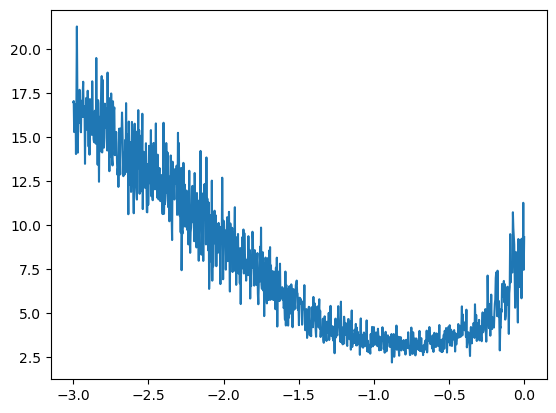

In [164]:
# Here, we determine visualls that the optimal learning rate is somewhere around the exponent of -1.0
# i.e. 10**-1 = 0.1
plt.plot(lr_i, loss_i)

In [165]:
# global loss
emb = C[X] # using minibatches, we are back to [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) # even better and more efficient than the above
loss

tensor(8.3079, grad_fn=<NllLossBackward0>)

## Using the optimal learning rate

In [170]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [171]:
for p in parameters:
    p.requires_grad = True

In [172]:
# Create random batches and only feed these batches forward and backward through the model

for i in range(10000):

    # construct minibatch
    ix = torch.randint(0, X.shape[0], (32,)) # Select 32 random indices from our dataset

    X_batch = X[ix]
    Y_batch = Y[ix]

    # forward pass
    emb = C[X_batch] # using minibatches, we are back to [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch) # even better and more efficient than the above

    # backward pass / backpropagation
    for p in parameters:
        p.grad = None # don't forget to .zero_grad() !!!
    loss.backward()

    # update
    learning_rate = 10**-1 # 0.1 as visually determined
    for p in parameters:
        p.data += -learning_rate * p.grad 
    
    # print(loss.item()) # NOTE: In this case, this is only the loss for the current batch!!! Not the global loss

In [173]:
# global loss
emb = C[X] # using minibatches, we are back to [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) # even better and more efficient than the above
loss

tensor(2.4732, grad_fn=<NllLossBackward0>)

In [174]:
# train split, dev/validation split, test split
# 80%, 10%, 10%
# train set is used to train the parameters
# validation set is used to train the hyperparameters (test different configurations)
# test set is used to evaluate the performance at the end

# Implement Train, Val and Test set

In [175]:
import random

In [178]:
# build the dataset
def buildDataset(words):
    '''
    Takes in a list of words and returns it's characters according to the block size as Tensors.
    '''
    block_size = 3 # context_length; how many characters do we use to support our prediction of the next character?
    X, Y = [], []

    for w in words:
        context = [0] * block_size # padded context of 0-tokens (i.e. ".")
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift/move the context window one character to the right --> rolling window of context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(.8 * len(words))
n2 = int(.9 * len(words))

Xtr, Ytr = buildDataset(words[:n1])
Xdev, Ydev = buildDataset(words[n1:n2])
Xtest, Ytest = buildDataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [179]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [180]:
for p in parameters:
    p.requires_grad = True

In [181]:
# Create random batches and only feed these batches forward and backward through the model

for i in range(50000):

    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # Select 32 random indices from our dataset

    X_batch = Xtr[ix]
    Y_batch = Ytr[ix]

    # forward pass
    emb = C[X_batch] # using minibatches, we are back to [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch) # even better and more efficient than the above

    # backward pass / backpropagation
    for p in parameters:
        p.grad = None # don't forget to .zero_grad() !!!
    loss.backward()

    # update
    learning_rate = 10**-1 # 0.1 as visually determined
    for p in parameters:
        p.data += -learning_rate * p.grad 
    
    # print(loss.item()) # NOTE: In this case, this is only the loss for the current batch!!! Not the global loss

In [183]:
# global loss across the TRAIN Set
emb = C[Xtr] # using minibatches, we are back to [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # even better and more efficient than the above
loss

tensor(2.3553, grad_fn=<NllLossBackward0>)

In [182]:
# global loss across the VALIDATION / DEV Set
emb = C[Xdev] # using minibatches, we are back to [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # even better and more efficient than the above
loss

tensor(2.3646, grad_fn=<NllLossBackward0>)

In [184]:
# Interpretation:
# Train loss and dev loss are roughly the same
# this means our model is underfitting
# our model is very tiny and not able to perfectly learn the complexity of the given problem
# therefore we expect performance increases by scaling up the neural network!

# Scaling up the Neural Network

In [185]:
# As we scale up the network, it will take longer to converge

In [186]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g) # lookup table for embeddings
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [187]:
for p in parameters:
    p.requires_grad = True

In [188]:
sum([p.numel() for p in parameters])

10281

In [192]:
# Create random batches and only feed these batches forward and backward through the model

for i in range(150000):

    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # Select 32 random indices from our dataset

    X_batch = Xtr[ix]
    Y_batch = Ytr[ix]

    # forward pass
    emb = C[X_batch] # using minibatches, we are back to [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch) # even better and more efficient than the above

    # backward pass / backpropagation
    for p in parameters:
        p.grad = None # don't forget to .zero_grad() !!!
    loss.backward()

    # update
    if i < 50000:
        learning_rate = 10**-1 # 0.1 as visually determined
    else:
        learning_rate = 0.01

    for p in parameters:
        p.data += -learning_rate * p.grad 
    
    # print(loss.item()) # NOTE: In this case, this is only the loss for the current batch!!! Not the global loss

In [193]:
# global loss across the TRAIN Set
emb = C[Xtr] # using minibatches, we are back to [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # even better and more efficient than the above
loss

tensor(2.2275, grad_fn=<NllLossBackward0>)

In [194]:
# global loss across the VALIDATION / DEV Set
emb = C[Xdev] # using minibatches, we are back to [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # even better and more efficient than the above
loss

tensor(2.2553, grad_fn=<NllLossBackward0>)

In [195]:
# We are still underfitting.
# Most likely, our 2D vector space for our embeddings is our bottleneck

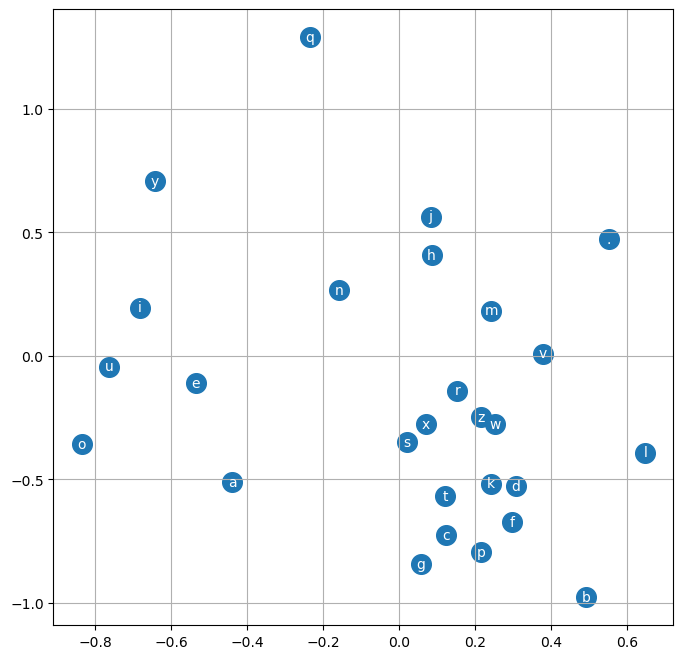

In [199]:
plt. figure (figsize=(8,8)) 
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt. text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid ( 'minor')